In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

In [4]:
import cifar10

In [6]:
#cifar10.data_path = "data/CIFAR-10/"

In [7]:
#cifar10.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [5]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [17]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [18]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [19]:
print("Size of:")
print("- Training-set:{}".format(len(images_train)))
print("- Test-set:{}".format(len(images_test)))

Size of:
- Training-set:50000
- Test-set:10000


In [20]:
from cifar10 import img_size, num_channels, num_classes

In [21]:
img_size_cropped = 24

In [22]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [23]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

In [24]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [25]:
y_true_cls = tf.argmax(y_true, dimension=1)

In [26]:
def pre_process_image(image, training):
    # This function takes a single image as input, and a boolean whether to build the training or testing graph.    
    if training:
        # For training, add the following to the TensorFlow graph.
        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

In [27]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [28]:
distorted_images = pre_process(images=x, training=True)

### Helper-function for creating Main Processing

In [29]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

### Helper-function for creating Neural Network

In [30]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Training Phase

In [31]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [32]:
_, loss = create_network(training=True)

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Create Neural Network for Test Phase / Inference

Now create the neural network for the test-phase. Once again the `create_network()` function returns the predicted class-labels `y_pred` for the input images, as well as the `loss`-function to be used during optimization. During testing we only need `y_pred`.

In [34]:
y_pred, _ = create_network(training=False)

In [35]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [36]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [37]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In [38]:
saver = tf.train.Saver()

### Getting the Weights

In [39]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope with the given layer_name. 
    # This is awkward because the TensorFlow function was really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [40]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### Getting the Layer Outputs

In [41]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

Get the output of the convoluational layers so we can plot them later.

In [42]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [43]:
session = tf.Session()

### Restore or initialize variables

Training this neural network may take a long time, especially if you do not have a GPU. We therefore save checkpoints during training so we can continue training at another time (e.g. during the night), and also for performing analysis later without having to train the neural network every time we want to use it.

If you want to restart the training of the neural network, you have to delete the checkpoints first.

This is the directory used for the checkpoints.

In [44]:
save_dir = 'checkpoints/'

Create the directory if it does not exist.

In [45]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the base-filename for the checkpoints, TensorFlow will append the iteration number, etc.

In [46]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

First try to restore the latest checkpoint. This may fail and raise an exception e.g. if such a checkpoint does not exist, or if you have changed the TensorFlow graph.

In [47]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_cnn-5081
Restored checkpoint from: checkpoints/cifar10_cnn-5081


### Helper-function to get a random training-batch

In [51]:
train_batch_size = 100

In [52]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)
    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]
    return x_batch, y_batch

### Helper-function to perform optimization

In [53]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples. x_batch now holds a batch of images and y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
 
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a checkpoint. Append the global_step counter to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

In [54]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.
    incorrect = (correct == False)
    images = images_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [55]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test,  
                          y_pred=cls_pred)  

    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### Helper-functions for calculating classifications

This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [56]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):

    num_images = len(images)
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [58]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for the classification accuracy

In [57]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Helper-function for showing the performance

In [59]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    correct, cls_pred = predict_cls_test()
    
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)


    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Helper-function for plotting convolutional weights

In [60]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables

    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

### Helper-function for plotting the output of convolutional layers

In [62]:
def plot_layer_output(layer_output, image):

    feed_dict = {x: [image]}
    
    values = session.run(layer_output, feed_dict=feed_dict)
    values_min = np.min(values)
    values_max = np.max(values)
    num_images = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_images))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Examples of distorted input images

In order to artificially inflate the number of images available for training, the neural network uses pre-processing with random distortions of the input images. This should hopefully make the neural network more flexible at recognizing and classifying images.

This is a helper-function for plotting distorted input images.

In [63]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    feed_dict = {x: image_duplicates}
    result = session.run(distorted_images, feed_dict=feed_dict)
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [64]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [65]:
img, cls = get_test_image(16)

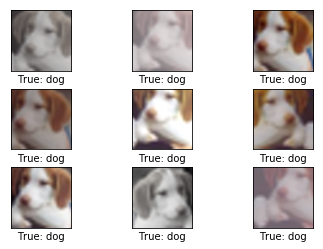

In [66]:
plot_distorted_image(img, cls)

## Perform optimization

In [63]:
optimize(num_iterations=5000)

Global Step:    100, Training Batch Accuracy:  34.4%
Global Step:    200, Training Batch Accuracy:  28.1%
Global Step:    300, Training Batch Accuracy:  48.4%
Global Step:    400, Training Batch Accuracy:  32.8%
Global Step:    500, Training Batch Accuracy:  32.8%
Global Step:    600, Training Batch Accuracy:  40.6%
Global Step:    700, Training Batch Accuracy:  31.2%
Global Step:    800, Training Batch Accuracy:  42.2%
Global Step:    900, Training Batch Accuracy:  31.2%
Global Step:   1000, Training Batch Accuracy:  48.4%
Saved checkpoint.
Global Step:   1100, Training Batch Accuracy:  43.8%
Global Step:   1200, Training Batch Accuracy:  46.9%
Global Step:   1300, Training Batch Accuracy:  59.4%
Global Step:   1400, Training Batch Accuracy:  59.4%
Global Step:   1500, Training Batch Accuracy:  45.3%
Global Step:   1600, Training Batch Accuracy:  35.9%
Global Step:   1700, Training Batch Accuracy:  48.4%
Global Step:   1800, Training Batch Accuracy:  54.7%
Global Step:   1900, Trainin

Accuracy on Test-Set: 60.0% (5996 / 10000)
Example errors:


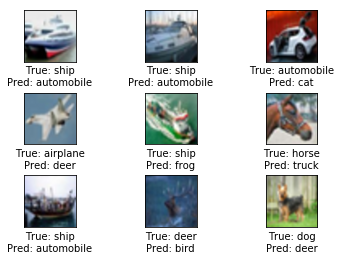

Confusion Matrix:
[610  84  94  12   9  12   9  30  73  67] (0) airplane
[ 16 808  15   9   2   7  13   7  20 103] (1) automobile
[ 46  37 495  80  58  88  91  69   9  27] (2) bird
[ 29  41  95 365  44 199  99  67   9  52] (3) cat
[ 29  24  76  52 395  62 100 218  17  27] (4) deer
[ 15  17 104 186  25 492  30 105   5  21] (5) dog
[  5  24  57  58  28  37 734  24   7  26] (6) frog
[  9  12  50  38  36  76  10 725   2  42] (7) horse
[ 60 122  14  16   5   7   6   8 638 124] (8) ship
[ 14 165  17   8   5   6  11  26  14 734] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [67]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Convolutional Weights

Min:  -0.58782, Max:   0.49697
Mean: 0.00085, Stdev: 0.16110


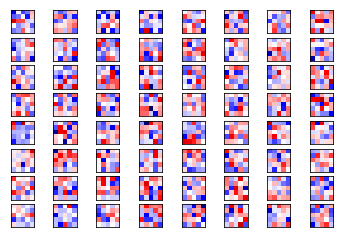

In [65]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Min:  -0.17227, Max:   0.17550
Mean: -0.00112, Stdev: 0.03643


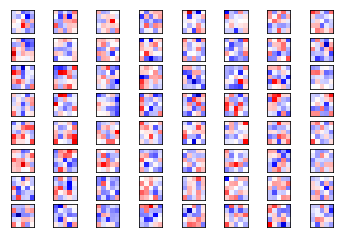

In [66]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers

In [67]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

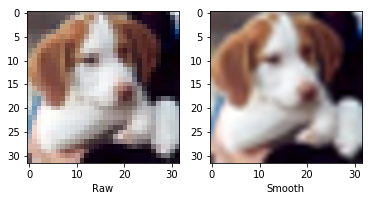

In [68]:
img, cls = get_test_image(16)
plot_image(img)

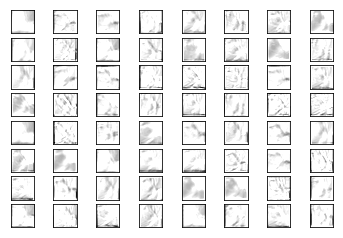

In [69]:
plot_layer_output(output_conv1, image=img)

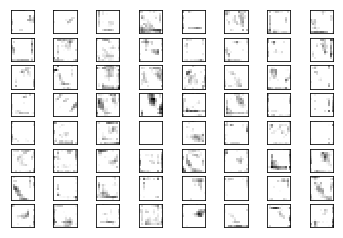

In [70]:
plot_layer_output(output_conv2, image=img)

In [71]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img]})

In [72]:
np.set_printoptions(precision=3, suppress=True)
print(label_pred[0])

[ 0.002  0.001  0.096  0.263  0.002  0.553  0.001  0.075  0.001  0.005]


In [73]:
class_names[3]

'cat'

In [74]:
class_names[5]

'dog'

In [70]:
session.close()